## SMIB

Synchronous Machine Infinite Bus (SMIB) system


### System analysis and simulation

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pydae.grid_tools as gt
import pydae.ssa as ssa
import pydae.ctrl as ctrl
import scipy.optimize as sopt
import scipy.signal as sctrl
import control as ct
from IPython.core.display import HTML,SVG
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

#### Initialization

In [107]:
import smib_pss

In [120]:
model = smib_pss.model()
params = {'p_m_1':1,'K_a_1':200, 'K_stab_1':0.0}
model.ini(params,'xy_0.json')
#model.save_xy_0('xy_1.json')

ssa.A_eval(model)
damp = ssa.damp_report(model)
damp.sort_values('Damp').round(2)

,Real,Imag,Freq.,Damp
Mode 3,-0.40,9.01,1.43,0.04
Mode 4,-0.40,-9.01,1.43,0.04
Mode 5,-7.64,1.84,0.29,0.97
Mode 6,-7.64,-1.84,0.29,0.97
Mode 1,-10.00,0.00,0.00,1.00
Mode 2,-0.01,0.00,0.00,1.00
Mode 7,-1.86,0.00,0.00,1.00
Mode 8,-0.00,0.00,0.00,1.00
Mode 9,-0.00,0.00,0.00,1.00
Mode 10,-1.00,0.00,0.00,1.00


#### Small signal analysis

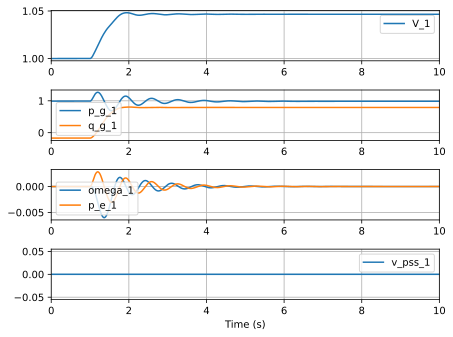

In [111]:
model = smib_pss.model()
model.Dt = 0.01
model.decimation = 1
model.ini( params,'xy_0.json')
model.run( 1.0,{})
model.run(20.0,{'v_ref_1':1.05})
model.post();

fig,axes = plt.subplots(nrows=4)

axes[0].plot(model.Time,  model.get_values('V_1'),label='V_1')

axes[1].plot(model.Time,  model.get_values('p_g_1'),label='p_g_1')
axes[1].plot(model.Time,  model.get_values('q_g_1'),label='q_g_1')

axes[2].plot(model.Time,  model.get_values('omega_1')-1,label='omega_1')
axes[2].plot(model.Time,  (model.get_values('p_e_1')-1)*0.01,label='p_e_1')

axes[3].plot(model.Time,  model.get_values('v_pss_1'),label='v_pss_1')


for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_xlim([0,10])
ax.set_xlabel('Time (s)')
fig.tight_layout()


In [16]:
class opt():

    def __init__(self,model):

        self.model = model

    def obj(self,x):

        omega = x[0]
        angle = x[1]
        # T_3 = x[2]
        # T_4 = x[3]
        K_stab = x[2]

        T_1,T_2 = ctrl.lead_design(angle,omega)

        T_3,T_4 =1,1
        # self.model.ini({'K_stab_1':K_stab,'T_1_pss_1':T_1,'T_2_pss_1':T_2,
        #                 'T_3_pss_1':T_3,'T_4_pss_1':T_4},'xy_0.json')
        model.set_value('T_1_pss_1',T_1)
        model.set_value('T_2_pss_1',T_2)
        model.set_value('K_stab_1',K_stab)

        ssa.A_eval(model)
        w,v = np.linalg.eig(ssa.A_eval(model))
        damps = -w.real/np.abs(w)
        min_damp = np.min(damps)
        return -min_damp
    
o = opt(model)
bounds = [(8.0,12.0),(-np.pi/2.1,np.pi/2.1),(0.1,30.0)]
result = sopt.minimize(o.obj,[9,0,1],bounds=bounds,method='Powell') # SLSQP, Nelder-Mead, Powell
        
result


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.21801753616276565
       x: [ 1.200e+01  1.496e+00  1.724e+00]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00]
           [-1.010e-04 -5.037e-05 -2.434e-05]]
    nfev: 166

In [17]:
ssa.A_eval(model)
damp = ssa.damp_report(model)
damp.sort_values('Damp').round(2)

,Real,Imag,Freq.,Damp
Mode 5,-3.10,13.9,2.21,0.22
Mode 6,-3.10,-13.9,2.21,0.22
Mode 1,-10.00,0.0,0.00,1.00
Mode 2,-1.00,0.0,0.00,1.00
Mode 3,-0.01,0.0,0.00,1.00
Mode 4,-320.88,0.0,0.00,1.00
Mode 7,-7.04,0.0,0.00,1.00
Mode 8,-3.18,0.0,0.00,1.00
Mode 9,-1.08,0.0,0.00,1.00
Mode 10,-0.10,0.0,0.00,1.00


#### Open-loop time domain simulation

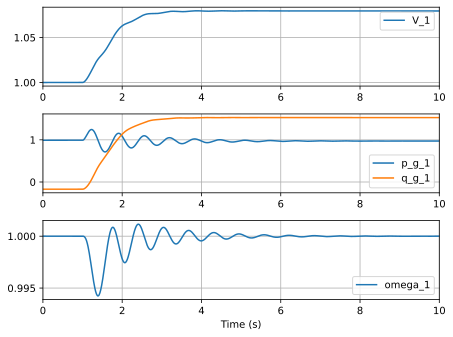

In [18]:
model = smib_pss.model()
model.Dt = 0.01
model.decimation = 1
model.ini(params,'xy_0.json')
model.run( 1.0,{})
model.run(20.0,{'v_ref_1':1.1})
model.post();

fig,axes = plt.subplots(nrows=3)

axes[0].plot(model.Time,  model.get_values('V_1'),label='V_1')

axes[1].plot(model.Time,  model.get_values('p_g_1'),label='p_g_1')
axes[1].plot(model.Time,  model.get_values('q_g_1'),label='q_g_1')

axes[2].plot(model.Time,  model.get_values('omega_1'),label='omega_1')

for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_xlim([0,10])
ax.set_xlabel('Time (s)')
fig.tight_layout()


10 states have been removed from the model


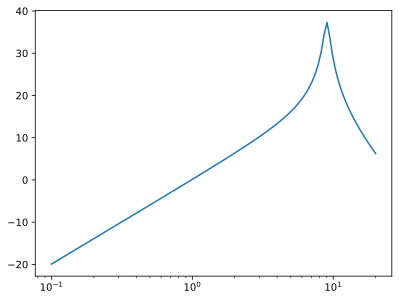

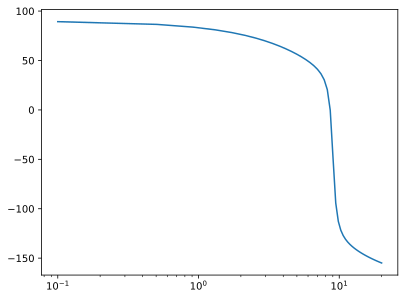

In [121]:
model = smib_pss.model()
model.ini(params,'xy_0.json')
#model.save_xy_0('xy_1.json')

ctrl.ss_eval(model)

u_idx = model.inputs_run_list.index('v_ref_1')
z_idx = model.outputs_list.index('p_e_1')
A = model.A.toarray()
B = model.B[:,u_idx].toarray()
C = model.C.toarray()[z_idx,:]
D = model.D.toarray()[z_idx,u_idx]

sys = ct.ss2tf(A,B,C,D)

sys = ct.minreal(sys, tol=1, verbose=True)

sys = sctrl.lti(sys.num[0][0],sys.den[0][0])

w, mag, phase = sctrl.bode(sys,w=np.linspace(0.1,20))
plt.figure()
plt.semilogx(w, mag)    # Bode magnitude plot
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.show()

In [123]:
omega_osc = 9.01 # w[np.argmax(mag)]
phase_vs2vt = np.deg2rad(phase[np.searchsorted(w,omega_osc)])

print(f'phase_vs2vt = {np.rad2deg(phase_vs2vt):0.1f}º')


T_wo = 10.0
G_wo = T_wo*1j*omega_osc/(T_wo*1j*omega_osc + 1)
phase_wo = np.angle(G_wo)

print(f'phase_wo = {np.rad2deg(phase_wo):0.1f}º')


phase_leads = -(phase_vs2vt + phase_wo)
print(f'Critical mode frequency = {omega_osc}')
print(f'phase_leads = {np.rad2deg(phase_leads):0.1f}º')

T_1,T_2 = ctrl.lead_design(phase_leads/2,omega_osc)
T_3,T_4 = ctrl.lead_design(phase_leads/2,omega_osc)

model = smib_pss.model()
params.update({'K_stab_1':20,
               'T_1_pss_1':T_1,'T_2_pss_1':T_2,
               'T_3_pss_1':T_3,'T_4_pss_1':T_4})
model.ini(params,'xy_0.json')

G = (T_1*1j*omega_osc + 1)/(T_2*1j*omega_osc + 1)*(T_3*1j*omega_osc + 1)/(T_4*1j*omega_osc + 1)
print(f'abs(G) = {np.abs(G)}, ang(G) = {np.angle(G, deg=True)}º')

ssa.A_eval(model)
damp = ssa.damp_report(model)
damp.sort_values('Damp').round(2)


phase_vs2vt = -49.1º
phase_wo = 0.6º
Critical mode frequency = 9.01
phase_leads = 48.4º
abs(G) = 2.3904915033726777, ang(G) = 48.42412123299041º


,Real,Imag,Freq.,Damp
Mode 4,1.88,18.16,2.89,-0.10
Mode 5,1.88,-18.16,2.89,-0.10
Mode 7,-5.93,1.46,0.23,0.97
Mode 8,-5.93,-1.46,0.23,0.97
Mode 1,-10.00,0.00,0.00,1.00
Mode 2,-0.01,0.00,0.00,1.00
Mode 3,-29.43,0.00,0.00,1.00
Mode 6,-7.70,0.00,0.00,1.00
Mode 9,-0.56,0.00,0.00,1.00
Mode 10,-0.12,0.00,0.00,1.00


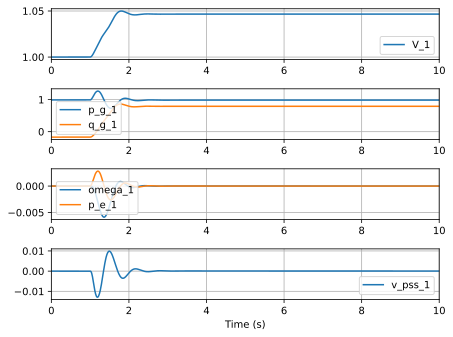

In [105]:
model = smib_pss.model()
model.Dt = 0.01
model.decimation = 1
model.ini( params,'xy_0.json')
model.run( 1.0,{})
model.run(20.0,{'v_ref_1':1.05})
model.post();

fig,axes = plt.subplots(nrows=4)

axes[0].plot(model.Time,  model.get_values('V_1'),label='V_1')

axes[1].plot(model.Time,  model.get_values('p_g_1'),label='p_g_1')
axes[1].plot(model.Time,  model.get_values('q_g_1'),label='q_g_1')

axes[2].plot(model.Time,  model.get_values('omega_1')-1,label='omega_1')
axes[2].plot(model.Time,  (model.get_values('p_e_1')-1)*0.01,label='p_e_1')

axes[3].plot(model.Time,  model.get_values('v_pss_1'),label='v_pss_1')


for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_xlim([0,10])
ax.set_xlabel('Time (s)')
fig.tight_layout()

In [52]:
model.report_y()

V_1   =  1.08
theta_1 =  0.03
V_2   =  1.00
theta_2 =  0.00
i_d_1 =  1.65
i_q_1 =  0.26
p_g_1 =  0.97
q_g_1 =  1.53
v_f_1 =  3.97
v_pss_1 =  0.00
omega_2 =  1.00
i_d_2 = -0.28
i_q_2 = -0.69
p_s_2 = -0.69
q_s_2 = -0.28
omega_coi =  1.00
p_agc =  0.00


## Continuos control 

In [ ]:
model.ini(params,'xy_1.json')
ssa.ss_eval(model)


A_f,B_f = model.A.toarray(), model.B.toarray()  # full matrices
C_f,D_f = model.C.toarray(), model.D.toarray()  # full matrices

idxs_u = [model.inputs_run_list.index(item) for item in ['v_f_1']]
idxs_z = [model.outputs_list.index(item) for item in ['V_1']]

Nx = model.N_x

A = A_f
B = B_f[:,idxs_u] 
C = C_f[idxs_z,:] 
D = D_f[idxs_z,idxs_u] 

Nu = B.shape[1]
Nz = C.shape[0]

def O(Nrow,Ncol):
    return np.zeros((Nrow,Ncol))
# y = C*x + D*u
# dx = A*x + B*u
# dxi = y_ref - y = y_ref - C*x - D*u
# x_e = [x,xi].T
# dx_e = A_e*x_e + B_e*u + B_ref*z_ref

Ny = 1
A_e = np.block([[ A, O(Nx,Ny)],
                [-C, O(Ny,Ny)]])
B_e = np.block([[       B],
                [ O(Nu,Nu)]])

FileNotFoundError: [Errno 2] No such file or directory: 'xy_1.json'

array([1.00000000e+00, 1.80397706e+01, 1.77187513e+02, 1.55186900e+03,
       6.86043868e+03, 4.90327342e+03])

### LQR continous

In [ ]:
import control

In [ ]:
N_xe = A_e.shape[0]
Q = np.eye(N_xe)
Q[model.x_list.index('delta_1'),model.x_list.index('delta_1')] = 10
Q[model.x_list.index('omega_1'),model.x_list.index('omega_1')] = 1000e3
Q[-1,-1] = 100e3
R = np.eye(Nu)*0.01

K, S, E = control.lqr(A_e, B_e, Q, R)

In [ ]:
Dt_mid = 0.1
times = np.arange(0.0,10,Dt_mid)
omegas = np.copy(times)
V_1s = np.copy(times)
v_fs = np.copy(times)

x = np.zeros((model.N_x,1))
xi = np.zeros((Nz,1))
x_e = np.zeros((model.N_x+Nz,1))
u = np.zeros((1,1))

for it,t in enumerate(times):
    
    #u[0] = 0.0
    #if t >1.0:
    #    u[0] = 0.5

    z_ref = 0.0
    if t >1.0:
        z_ref = 0.1
    
    u = -K@x_e
    x += Dt_mid*(A @ x + B @ u)
    z  = C @ x + D @ u
    
    xi += Dt_mid*(z_ref - z)
    
    x_e = np.block([[x],[xi]])
    
    v_fs[it] = u
    omegas[it] = x[model.x_list.index('omega_1')]
    V_1s[it] = z

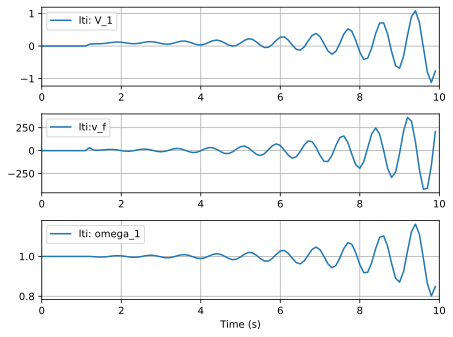

In [ ]:
fig,axes = plt.subplots(nrows=3)

axes[0].plot(times,  V_1s,label='lti: V_1')
axes[1].plot(times,  v_fs,label='lti:v_f')
axes[2].plot(times,  omegas+1,label='lti: omega_1')

for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_xlim([0,10])
ax.set_xlabel('Time (s)')
fig.tight_layout()

In [ ]:
model = smib.model()
model.Dt = 0.001
model.decimation = 1
model.ini(params,'xy_1.json')

v_f_1_0 = model.get_value('v_f_1')
z_0 = model.get_value('V_1')
x_0 = np.copy(model.xy[:model.N_x].reshape((model.N_x,1)))

Dt_mid = 0.1
times = np.arange(0.0,10,Dt_mid)

x = np.zeros((model.N_x,1))
xi = np.zeros((Nz,1))
x_e = np.zeros((model.N_x+Nz,1))
u = np.zeros((1,1))

for it,t in enumerate(times):
    
    #u[0] = 0.0
    #if t >1.0:
    #    u[0] = 0.5

    z_ref = 0.0
    if t >1.0:
        z_ref = 0.1
    

    x = model.xy[:model.N_x].reshape((model.N_x,1)) - x_0
    z  = model.get_value('V_1') - z_0
    
    xi += Dt_mid*(z_ref - z)
    
    x_e = np.block([[x],[xi]])
    u = -K@x_e    
    
    v_f_nosat = u + v_f_1_0
    if v_f_nosat>1000.0: 
        v_f = 1000
    model.run(t,{'v_f_1':v_f_nosat})
model.post();


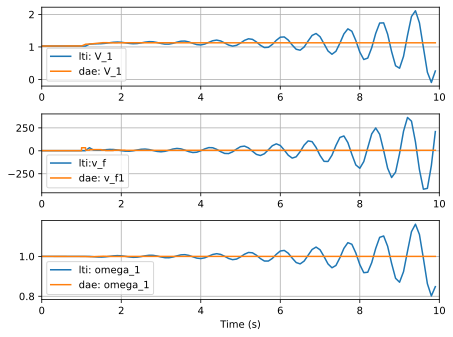

In [ ]:
fig,axes = plt.subplots(nrows=3)

V_1_0 = model.get_values('V_1')[0]
v_f_1_0 = model.get_values('v_f_1')[0]
axes[0].plot(times,  V_1s+V_1_0,label='lti: V_1')
axes[1].plot(times,  v_fs+v_f_1_0,label='lti:v_f')
axes[2].plot(times,  omegas+1,label='lti: omega_1')


axes[0].plot(model.Time,  model.get_values('V_1'),label='dae: V_1')
axes[1].plot(model.Time,  model.get_values('v_f_1'),label='dae: v_f1')
axes[2].plot(model.Time,  model.get_values('omega_1'),label='dae: omega_1')

#axes[1].plot(times,  omegas+1,label='lti: omega_1')

for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_xlim([0,10])
ax.set_xlabel('Time (s)')
fig.tight_layout()

In [ ]:
ssa.damp(A_e-K*B_e)

,Real,Imag,Freq.,Damp
Mode 1,-3.632944,7.171170,1.141327,0.451920
Mode 2,-3.632944,-7.171170,1.141327,0.451920
Mode 3,-4.154596,5.608837,0.892674,0.595218
Mode 4,-4.154596,-5.608837,0.892674,0.595218
Mode 5,-4.564992,0.000000,0.000000,1.000000
Mode 6,-0.001000,0.000000,0.000000,1.000000
Mode 7,-0.010000,0.000000,0.000000,1.000000
Mode 8,-0.000001,0.000000,0.000000,1.000000


## LQR discrete

In [ ]:
model.ini(params,'xy_1.json')
ctrl.ss_eval(model)
Dt_mid = 0.1
A_d_f,B_d_f = ctrl.discretise_time(model.A.toarray(),model.B.toarray(), Dt_mid)
C_d_f,D_d_f = model.C.toarray(), model.D.toarray()  # full matrices


idxs_u = [model.inputs_run_list.index(item) for item in ['v_f_1']]
idxs_z = [model.outputs_list.index(item) for item in ['V_1']]

Nx = model.N_x

A_d = A_d_f
B_d = B_d_f[:,idxs_u] 
C_d = C_d_f[idxs_z,:] 
D_d = D_d_f[idxs_z,idxs_u] 

Nu = B.shape[1]
Nz = C.shape[0]

def O(Nrow,Ncol):
    return np.zeros((Nrow,Ncol))
# y_k = C*x_k + D*u_k
# x_k1  = A*x_k + B*u_k
# xi_k1 = xi_k + Dt*(y_ref - y_k) = xi_k + Dt*(y_ref - C*x_k - D*u_k) = xi_k - Dt*C*x_k
# x_e_k = [x_k,xi_k].T
# dx_e_k1 = A_e*x_e_k + B_e*u_k + B_ref*z_ref

Ny = 1
A_e = np.block([[        A_d,   O(Nx,Ny)],
                [-Dt_mid*C_d, np.eye(Ny)]])
B_e = np.block([[       B_d],
                [  O(Nu,Nu)]])

N_xe = A_e.shape[0]
Q = np.eye(N_xe)
Q[model.x_list.index('delta_1'),model.x_list.index('delta_1')] = 1
Q[model.x_list.index('omega_1'),model.x_list.index('omega_1')] = 100e3
Q[-1,-1] = 100e3
R = np.eye(Nu)*0.01

K_d, S, E = ctrl.dlqr(A_e, B_e, Q, R)

### Simulation on linear system

In [ ]:
times = np.arange(0.0,20,Dt_mid)

omegas = np.copy(times)
V_1s = np.copy(times)

x_k  = np.zeros((model.N_x,1))
xi_k = np.zeros((1,1))

N_t = len(times)
U = np.zeros((N_t,Nu))
X = np.zeros((N_t,model.N_x))
Z = np.zeros((N_t,Nz))
Z_ref = np.zeros((N_t,Nz))

u_k = np.zeros((1,1))

for it,t in enumerate(times):
    
    z_ref = 0.0
    if t >1.0:
        z_ref = 0.1
    
    x_ek = np.block([[x_k],[xi_k]])
    u_k = -K_d@x_ek
    
    x_k1 = A_d @ x_k + B_d @ u_k
    z    = C_d @ x_k + D_d @ u_k
    
    xi_k1 = xi_k + Dt_mid*(z_ref - z)
    
    x_k = np.copy(x_k1)
    xi_k = np.copy(xi_k1)
    
    
    U[it,:] = u_k
    X[it,:] = x_k.T
    Z[it,:] = z
    Z_ref[it,:] = z_ref



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


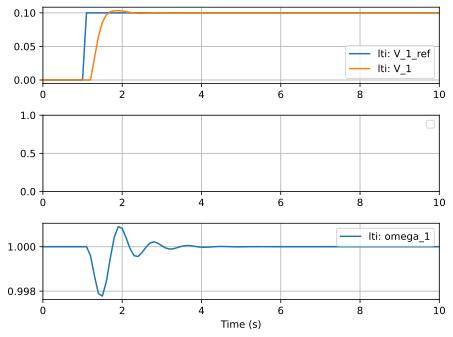

In [ ]:
fig,axes = plt.subplots(nrows=3)

axes[0].plot(times,  Z_ref[:,0],label='lti: V_1_ref')
axes[0].plot(times,  Z[:,0],label='lti: V_1')

axes[2].plot(times,  X[:,model.x_list.index('omega_1')]+1,label='lti: omega_1')

for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_xlim([0,10])
ax.set_xlabel('Time (s)')
fig.tight_layout()

### Simulation on DAE system

In [ ]:
model = smib.model()
model.Dt = 0.01
model.decimation = 1
model.ini(params,'xy_1.json')

v_f_1_0 = model.get_value('v_f_1')
z_0 = model.get_value('V_1')
x_0 = np.copy(model.xy[:model.N_x].reshape((model.N_x,1)))


times = np.arange(0.0,20,Dt_mid)

xi_k = np.zeros((1,1))
u_k = np.zeros((1,1))

for it,t in enumerate(times):
    
    z_ref = 0.0
    if t >1.0:
        z_ref = 0.1
    
    x_ek = np.block([[x],[xi_k]])
    u = -K_d@x_ek

    v_f_nosat = u + v_f_1_0
    if v_f_nosat>1000.0: 
        v_f = 1000
    model.run(t,{'v_f_1':v_f_nosat})
    
    x = model.xy[:model.N_x].reshape((model.N_x,1)) - x_0
    z  = model.get_value('V_1') - z_0
    
    xi_k1 = xi_k + Dt_mid*(z_ref - z)
    
    xi_k = np.copy(xi_k1)
     

model.post();

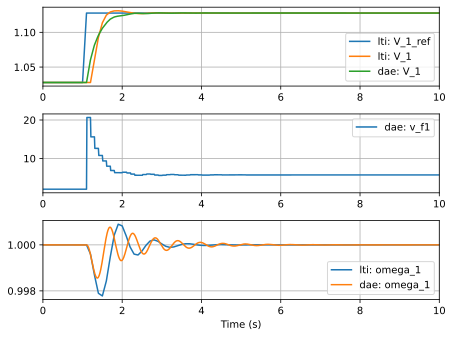

In [ ]:
fig,axes = plt.subplots(nrows=3)

V_1_0 = model.get_values('V_1')[0]
v_f_1_0 = model.get_values('v_f_1')[0]

axes[0].plot(times,  Z_ref[:,0]+V_1_0,label='lti: V_1_ref')
axes[0].plot(times,  Z[:,0]+V_1_0,label='lti: V_1')

axes[2].plot(times,  X[:,model.x_list.index('omega_1')]+1,label='lti: omega_1')


axes[0].plot(model.Time,  model.get_values('V_1'),label='dae: V_1')
axes[1].plot(model.Time,  model.get_values('v_f_1'),label='dae: v_f1')
axes[2].plot(model.Time,  model.get_values('omega_1'),label='dae: omega_1')

#axes[1].plot(times,  omegas+1,label='lti: omega_1')

for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_xlim([0,10])
ax.set_xlabel('Time (s)')
fig.tight_layout()

In [ ]:
model.ini(params,'xy_1.json')

Dt_mid = 0.1

#x_d_ctrl_list = ['i']   # states to consider in the reduction
z_ctrl_list = ['V_1']     # outputs to consider in the controller
u_ctrl_list = ['v_f_1']   # intputs to consider in the controller
z_ctrl_idxs = [model.outputs_list.index(item)    for item in z_ctrl_list]
u_ctrl_idxs = [model.inputs_run_list.index(item) for item in u_ctrl_list]

# linear continous plant
ctrl.ss_eval(model)
A_p = model.A.toarray()
B_p = model.B.toarray()
C_p = model.C.toarray()
D_p = model.D.toarray()

# plant discretization
A_d,B_d,C_d,D_d,Dt = sctrl.cont2discrete((A_p,B_p,C_p,D_p),Dt_mid,method='zoh')

N_z_d,N_x_d = C_d.shape  # discreticed plant dimensions
N_x_d,N_u_d = B_d.shape

# Controller ##################################################################################
B_c = B_d[:,u_ctrl_idxs]  # only control inputs               
C_c = C_d[z_ctrl_idxs,:]  # only control outputs
D_c = D_d[z_ctrl_idxs,:][:,u_ctrl_idxs]

N_x_c,N_u_d = B_c.shape
N_z_c,N_x_c = C_c.shape
N_u_zref = len(z_ctrl_list)

O_ux = np.zeros((N_u_d,N_x_d))
O_rx = np.zeros((N_u_d,N_x_d))
O_xi = np.zeros((N_x_d,N_u_zref))
O_rr = np.zeros((N_u_d,N_u_d))
O_ri = np.zeros((N_u_d,N_u_zref))
O_iu = np.zeros((N_u_zref,N_u_d))
O_xz = np.zeros((N_x_d,2))

O_rz = np.zeros((N_u_d,2))

I_ii = np.eye(N_u_zref)
I_ru = np.eye(N_u_d)
O_xu = np.zeros((N_x_d,N_u_d))

# discretized plant:
# Δx_d = A_d*Δx_d + B_d*Δu_d
# Δz_c = C_c*Δx_d + D_c*Δu_d

# dinamic extension:
# Δx_d = A_d*Δx_d + B_d*Δu_d
# Δx_i = Δx_i + Δt*(Δz_c-Δz_c_ref) = Δx_i + Δt*C_c*Δx_d - Dt*Δz_c_ref
# Δz_c = z_c - z_c_0
# Δz_c_ref = z_c_ref - z_c_0
# (Δz_c-Δz_c_ref) = z_c - z_c_ref

# dinamic extension:
# Δx_d = A_d*Δx_d + B_c*Δx_r
# Δx_r = Δu_d
# Δx_i = Δx_i + Δt*(Δz_c-Δz_c_ref) = Δx_i + Δt*(C_c*Δx_d + D_c*Δx_r) - Dt*Δz_c_ref
# Δz_c = z_c - z_c_0
# Δz_c_ref = z_c_ref - z_c_0
# (Δz_c-Δz_c_ref) = z_c - z_c_ref
# agregar washouts, poner delay doble

Δt = Dt_mid
Nx,Nr,Ni,Nu,Nz = model.N_x,N_u_d,N_z_c,N_u_d,N_z_c
A_e = np.block([
                [        A_d,      B_c, O(Nx,Ni)],    # Δx_d: plant states
                [   O(Nr,Nx), O(Nr,Nr), O(Nr,Ni)],    # Δx_r: added delay states
                [     Δt*C_c,   Δt*D_c, I(Ni,Ni)],    # Δx_i: added integrators    
               ])

B_e = np.block([
                [O(Nx,Nr)],
                [I(Nr,Nr)],
                [O(Ni,Nr)],    
               ])

B_eref = np.block([
                [    O(Nx,Nz)],
                [    O(Nr,Nz)],
                [-Δt*I(Ni,Ni)],    
               ])

C_e  = np.block([ C_c, np.zeros((2,16+2))])
# weighting matrices
Q_c = np.eye(A_e.shape[0])*0.1
for ig,name in enumerate(gen_buses):
    idx = model.x_list.index(f'xi_v_{name}')
    Q_c[idx,idx] = 0.0
    idx = model.x_list.index(f'delta_{name}')
    Q_c[idx,idx] = 2
    idx = model.x_list.index(f'x_v_{name}')
    Q_c[idx,idx] = 10
    
#idx = model.x_list.index('delta_19')
#Q_c[idx,idx] = 0.0001
#idx = model.x_list.index('Domega_19')
#Q_c[idx,idx] = 0.0001
#idx = model.x_list.index('xi_freq')
#Q_c[idx,idx] = 0.0001
#
Q_c[-1,-1] = 200
Q_c[-2,-2] = 200
Q_c[-1,-2] = 10
Q_c[-2,-1] = 10

R_c = np.eye(B_e.shape[1])

K_c,S_c,E_c = ctrl.dlqr(A_e,B_e,Q_c,R_c)

E_cont = np.log(E_c)/Δt

damp = -E_cont.real/(np.abs(E_cont))
print(np.sort(damp))

#ctrl.A_eval(model)
#ctrl.damp_report(model).sort_values('Damp').round(4)

NameError: name 'sctrl' is not defined

In [ ]:
115/20e3

0.00575

In [ ]:
115*400

46000